In [1]:
from utils import load_images_as_tensors
import sys
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt

current_dir = Path.cwd()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Added project root to sys.path: {project_root}")
try:
    from scripts.utils import create_model
    print("✅ Successfully imported target_function_name from scripts/utils.py!")
except ImportError as e:
    print(f"❌ Error importing from scripts/utils.py: {e}")
    print("Please check that 'scripts/utils.py' and 'target_function_name' exist.")

Added project root to sys.path: /cluster/home/jiapan/Supervised_Research
✅ Successfully imported target_function_name from scripts/utils.py!


## 0. Config

In [2]:
# images
SAMPLE_IMAGES_DIR = "/cluster/work/lawecon_repo/gravestones/rep_learning_dataset/sample_images"
IMAGE_EXTS = {".jpg", ".jpeg", ".png"}

# device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)

# model checkpoint
ckpt_dir = "/cluster/home/jiapan/Supervised_Research/checkpoints"
model_type = "mae"
ckpt_name = "epoch_30.pth"

device: cpu


## 1. Load Data

In [3]:
# Load all images and convert them to tensors
image_tensors_list = load_images_as_tensors(SAMPLE_IMAGES_DIR, IMAGE_EXTS)

# --- Verification and Summary ---

num_loaded = len(image_tensors_list)
print(f"\n--- Summary ---")
print(f"Successfully loaded and converted **{num_loaded}** images to PyTorch tensors.")

if num_loaded > 0:
    # Check the type and shape of the first tensor
    first_tensor = image_tensors_list[0]
    print(f"Type of first element: **{type(first_tensor)}**")
    print(f"Shape of first tensor (C, H, W): **{first_tensor.shape}**")
    print(f"Data type (dtype): **{first_tensor.dtype}**")
    print(f"Min/Max values: **{first_tensor.min():.4f}** / **{first_tensor.max():.4f}**")

print("\nAll image tensors are now available in the `image_tensors_list` list.")

Searching for images in: /cluster/work/lawecon_repo/gravestones/rep_learning_dataset/sample_images

--- Summary ---
Successfully loaded and converted **100** images to PyTorch tensors.
Type of first element: **<class 'torch.Tensor'>**
Shape of first tensor (C, H, W): **torch.Size([3, 256, 256])**
Data type (dtype): **torch.float32**
Min/Max values: **0.0000** / **0.8275**

All image tensors are now available in the `image_tensors_list` list.


## 2. Create Encoder & Load Checkpoint

In [4]:
# new model object
model, _ = create_model(type=model_type, device=DEVICE)

# load checkpoint
ckpt_path = os.path.join(ckpt_dir, model_type, ckpt_name)
state_dict = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()
print(f"✅ Successfully loaded MAE model weights from: {ckpt_path}")


          Creating MAE model ...

✅ Successfully loaded MAE model weights from: /cluster/home/jiapan/Supervised_Research/checkpoints/mae/epoch_30.pth


## 3. Forward Pass on Sample Images

In [5]:
START_IDX = 20
NUM_SAMPLES = 5

sample_tensors = image_tensors_list[START_IDX:START_IDX+NUM_SAMPLES]
image_batch = torch.stack(sample_tensors, dim=0).to(DEVICE)
print(f"Successfully created a batch of {image_batch.shape[0]} images.")
print(f"Batch shape: {image_batch.shape}")

# get full reconstruction
with torch.no_grad():
    latent_embeddings = model.encoder(image_batch)

# 5. Print the size of the output tensor
print("\n--- Model Output ---")
print(f"Shape of latent embeddings (Encoder Output Size): **{latent_embeddings.shape}**")
print(f"The number of embeddings is {latent_embeddings.shape[0]}, and the dimensionality is {latent_embeddings.shape[1]}.")

Successfully created a batch of 5 images.
Batch shape: torch.Size([5, 3, 256, 256])

--- Model Output ---
Shape of latent embeddings (Encoder Output Size): **torch.Size([5, 768])**
The number of embeddings is 5, and the dimensionality is 768.


## 4. Visualize Latent Embeddings and Reconstructions

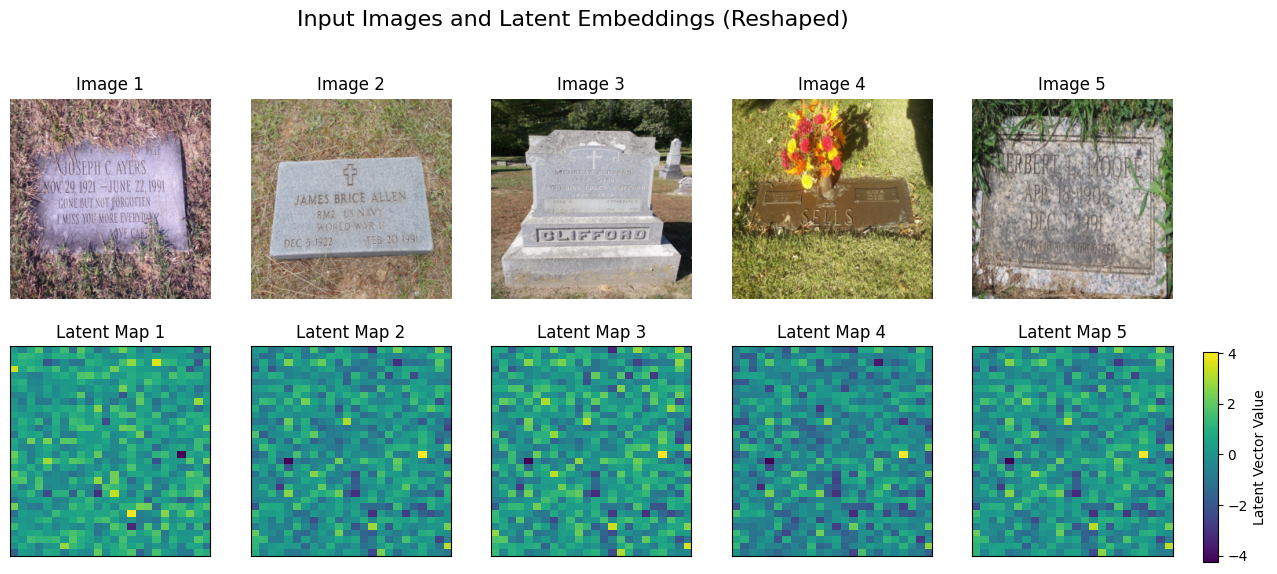

In [6]:
# --- VISUALIZATION PARAMETERS ---
FEATURE_MAP_SHAPE = (32, 24)    # 32 * 24 = 768

# --- PLOTTING ---
fig, axes = plt.subplots(
    nrows=2, 
    ncols=NUM_SAMPLES, 
    figsize=(3 * NUM_SAMPLES, 6),
)

plt.suptitle(
    f"Input Images and Latent Embeddings (Reshaped)", 
    fontsize=16, 
    y=1.02
)

for i in range(NUM_SAMPLES):
    # --- Row 1: Original Input Image (3x256x256) ---
    ax_img = axes[0, i]
    
    # PyTorch format is C x H x W; Matplotlib needs H x W x C
    img_display = image_batch[i].permute(1, 2, 0).numpy()
    
    # Ensure image is in the correct range for plotting (0-1 floats or 0-255 ints)
    ax_img.imshow(img_display)
    ax_img.set_title(f"Image {i+1}", fontsize=12)
    ax_img.axis('off')

    # --- Row 2: Latent Embedding (768-dim) ---
    ax_latent = axes[1, i]

    # Reshape the 768-dim vector into a 2D feature map
    latent_map = latent_embeddings[i].view(*FEATURE_MAP_SHAPE).numpy()
    
    # Use imshow to visualize the 2D array. 'cmap' sets the color scheme.
    # 'interpolation' is set to 'nearest' for a sharp, pixelated look.
    im = ax_latent.imshow(latent_map, cmap='viridis', aspect='auto', interpolation='nearest')
    
    ax_latent.set_title(f"Latent Map {i+1}", fontsize=12)
    ax_latent.set_xticks([])
    ax_latent.set_yticks([])

# Add a colorbar to the right of the entire latent row to show value mapping
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.35])      # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Latent Vector Value')

plt.show()